In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

# Checks if a CUDA enabled GPU is available and prints out its information
if torch.cuda.is_available():
    print("CUDA is available!")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        
    device = torch.device("cuda:0")

else:
    print("CUDA is not available.")
    device = torch.device("cpu")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# # Standardize the data & Apply the transformation to outliers
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# inliers_array = scaler.fit_transform(inliers_array)
# outliers_array = scaler.transform(outliers_array)

CUDA is not available.
/kaggle/input/anomaly/amonaly.csv


In [2]:
# 1. Data Access & Processing
# ---------------------------------------

# Read data and get basic info
data = pd.read_csv("/kaggle/input/anomaly/amonaly.csv")

# Exclude columns 0, 42, and 43
data = data.drop(columns=['Unnamed: 0', 'seq_id_global', 'LabelName'])

# Sort by outlier column
data_sorted = data.sort_values('outlier')

# Get total count of inliers (0s)
inliers_count = (data_sorted['outlier'] == 0).sum()

# Calculate split sizes based on total inliers (75%, 12.5%, 12.5%)
train_size = int(0.75 * inliers_count)
val_size = int(0.125 * inliers_count)
# test_size will be whatever is left (approximately 12.5%)
train_data = data_sorted.iloc[:train_size]

# Split remaining inliers and outliers
val_inliers = data_sorted.iloc[train_size:train_size+val_size]
test_inliers = data_sorted.iloc[train_size+val_size:inliers_count]
outliers = data_sorted.iloc[inliers_count:]

# Calculate sizes for balanced val and test sets
total_outliers = len(outliers)
val_outliers_size = total_outliers // 2
test_outliers_size = total_outliers - val_outliers_size  # This ensures we use all outliers

# Create balanced validation set
val_outliers = outliers.iloc[:val_outliers_size]
val_data = pd.concat([val_inliers, val_outliers]).sample(frac=1, random_state=42)

# Create balanced test set
test_outliers = outliers.iloc[val_outliers_size:]  # Take all remaining outliers
test_data = pd.concat([test_inliers, test_outliers]).sample(frac=1, random_state=43)

# Separate features and labels
# Keep train labels for immediate split check only
train_features = train_data.drop('outlier', axis=1)
train_labels = train_data['outlier']
val_features = val_data.drop('outlier', axis=1)
val_labels = val_data['outlier']
test_features = test_data.drop('outlier', axis=1)
test_labels = test_data['outlier']

# Convert to torch tensors
train_tensor = torch.tensor(train_features.values, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.float32)
val_features_tensor = torch.tensor(val_features.values, dtype=torch.float32)
val_labels_tensor = torch.tensor(val_labels.values, dtype=torch.float32)
test_features_tensor = torch.tensor(test_features.values, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels.values, dtype=torch.float32)

In [3]:
# 2. Assess Preprocessing
# ---------------------------------------

# Print dataset sizes for verification
print(f"Total inliers: {inliers_count}")
print(f"Total Outliers: {total_outliers}")
print(f"Training set size: {len(train_data)} ({(len(train_data)/inliers_count)*100:.1f}% of inliers)")
print(f"Validation set size: {len(val_data)} (inliers: {len(val_inliers)}, outliers: {len(val_outliers)})")
print(f"Test set size: {len(test_data)} (inliers: {len(test_inliers)}, outliers: {len(test_outliers)})")

print(train_tensor.shape)
print(train_labels_tensor.shape)
print(val_features_tensor.shape)
print(val_labels_tensor.shape)
print(test_features_tensor.shape)
print(test_labels_tensor.shape)

print(f"Inliers in Train Tensor: {sum(1 for label in train_labels if label == 0)}")
print(f"Outliers in Train Tensor: {sum(1 for label in train_labels if label == 1)}")
print(f"Inliers in Val Tensor: {sum(1 for label in val_labels_tensor if label == 0)}")
print(f"Outliers in Val Tensor: {sum(1 for label in val_labels_tensor if label == 1)}")
print(f"Inliers in Test Tensor: {sum(1 for label in test_labels_tensor if label == 0)}")
print(f"Outliers in Test Tensor: {sum(1 for label in test_labels_tensor if label == 1)}")
print(f"Total Ouliers: {(data_sorted['outlier'] == 1).sum()}")

Total inliers: 10039
Total Outliers: 921
Training set size: 7529 (75.0% of inliers)
Validation set size: 1714 (inliers: 1254, outliers: 460)
Test set size: 1717 (inliers: 1256, outliers: 461)
torch.Size([7529, 51])
torch.Size([7529])
torch.Size([1714, 51])
torch.Size([1714])
torch.Size([1717, 51])
torch.Size([1717])
Inliers in Train Tensor: 7529
Outliers in Train Tensor: 0
Inliers in Val Tensor: 1254
Outliers in Val Tensor: 460
Inliers in Test Tensor: 1256
Outliers in Test Tensor: 461
Total Ouliers: 921


In [4]:
# 3. Dataset and Dataloader Creation
# ---------------------------------------

# Define the AnomalyDataset class
class AnomalyDataset(Dataset):
    def __init__(self, features, labels=None):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        if self.labels is None:
            return self.features[idx], self.features[idx]  # For training (autoencoder)
        return self.features[idx], self.labels[idx]  # For validation and testing

# Create the datasets
train_dataset = AnomalyDataset(train_tensor)  # No labels for training
val_dataset = AnomalyDataset(val_features_tensor, val_labels_tensor)
test_dataset = AnomalyDataset(test_features_tensor, test_labels_tensor)

# Parameters
batch_size = 64
shuffle = True
input_dim = train_tensor.shape[1]

# Create the DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)

In [5]:
# 4. Model Creation, Definition, and instantiation
# ---------------------------------------

class EnhancedAutoencoderFunctional(nn.Module):
    def __init__(self, input_dim, latent_dim=32, dropout_rate=0.1):
        super(EnhancedAutoencoderFunctional, self).__init__()
        
        # Architecture parameters
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.dropout_rate = dropout_rate
        
        # Encoder layers
        self.encoder_fc1 = nn.Linear(input_dim, 128)
        self.encoder_bn1 = nn.BatchNorm1d(128)
        self.encoder_fc2 = nn.Linear(128, 64)
        self.encoder_bn2 = nn.BatchNorm1d(64)
        self.encoder_fc3 = nn.Linear(64, latent_dim)
        self.encoder_bn3 = nn.BatchNorm1d(latent_dim)
        # self.encoder_fc4 = nn.Linear(latent_dim, 16)
        # self.encoder_bn4 = nn.BatchNorm1d(16)
        
        # Decoder layers
        # self.decoder_fc4 = nn.Linear(16, latent_dim)
        # self.decoder_bn4 = nn.BatchNorm1d(latent_dim)
        self.decoder_fc1 = nn.Linear(latent_dim, 64)
        self.decoder_bn1 = nn.BatchNorm1d(64)
        self.decoder_fc2 = nn.Linear(64, 128)
        self.decoder_bn2 = nn.BatchNorm1d(128)
        self.decoder_fc3 = nn.Linear(128, input_dim)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)

        # Initialize weights
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='leaky_relu')
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
    
    def encode(self, x):
        # Encoder forward pass
        x = self.encoder_fc1(x)
        x = self.encoder_bn1(x)
        x = F.leaky_relu(x, 0.2)
        x = self.dropout(x)
        
        x = self.encoder_fc2(x)
        x = self.encoder_bn2(x)
        x = F.leaky_relu(x, 0.2)
        x = self.dropout(x)
        
        x = self.encoder_fc3(x)
        x = self.encoder_bn3(x)
        
        return x
    
    def decode(self, x):
        # Decoder forward pass
        x = self.decoder_fc1(x)
        x = self.decoder_bn1(x)
        x = F.leaky_relu(x, 0.2)
        x = self.dropout(x)
        
        x = self.decoder_fc2(x)
        x = self.decoder_bn2(x)
        x = F.leaky_relu(x, 0.2)
        x = self.dropout(x)
        
        x = self.decoder_fc3(x)
        x = torch.tanh(x)  # Output activation
        
        return x
    
    def forward(self, x):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return decoded

In [6]:
# 5. Model Instantiation
# ---------------------------------------

def create_model(input_dim, device=device):
    model = EnhancedAutoencoderFunctional(input_dim).to(device)
    
    # Loss function combining MSE and L1 regularization
    criterion = lambda x, y: (
        F.mse_loss(x, y) + 
        0.1 * F.l1_loss(x, y)
    )
    
    # Optimizer with weight decay
    optimizer = optim.AdamW(
        model.parameters(),
        lr=0.001,
        weight_decay=0.01,
        betas=(0.9, 0.999)
    )
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=5,
    )
    
    return model, criterion, optimizer, scheduler

model, criterion, optimizer, scheduler = create_model(input_dim)

Epoch [5/150], Train Loss: 0.2521, Val Loss: 0.4716
Epoch [10/150], Train Loss: 0.2259, Val Loss: 0.4544
Epoch [15/150], Train Loss: 0.2172, Val Loss: 0.4515
Epoch [20/150], Train Loss: 0.2126, Val Loss: 0.4451
Epoch [25/150], Train Loss: 0.2086, Val Loss: 0.4427
Epoch [30/150], Train Loss: 0.2049, Val Loss: 0.4450
Epoch [35/150], Train Loss: 0.2035, Val Loss: 0.4379
Epoch [40/150], Train Loss: 0.2016, Val Loss: 0.4394
Epoch [45/150], Train Loss: 0.1996, Val Loss: 0.4358
Epoch [50/150], Train Loss: 0.1994, Val Loss: 0.4362
Early stopping triggered at epoch 53


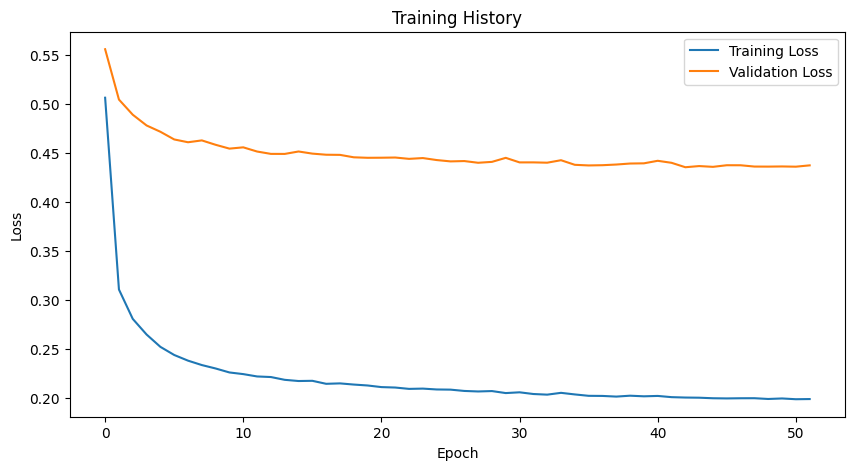

In [7]:
# 6. Model Training
# ---------------------------------------

# Training function with improved monitoring
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                num_epochs=150, device=device):
    
    best_val_loss = float('inf')
    early_stopping_patience = 10
    early_stopping_counter = 0
    training_history = {'train_loss': [], 'val_loss': []}
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        for batch_features, _ in train_loader:
            batch_features = batch_features.to(device)
            
            # Forward pass
            outputs = model(batch_features)
            loss = criterion(outputs, batch_features)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
            
        avg_train_loss = train_loss / len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_features, _ in val_loader:
                batch_features = batch_features.to(device)
                outputs = model(batch_features)
                loss = criterion(outputs, batch_features)
                val_loss += loss.item()
                
        avg_val_loss = val_loss / len(val_loader)
        
        # Update learning rate
        scheduler.step(avg_val_loss)
        
        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stopping_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            early_stopping_counter += 1
            
        if early_stopping_counter >= early_stopping_patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
            
        # Record history
        training_history['train_loss'].append(avg_train_loss)
        training_history['val_loss'].append(avg_val_loss)
        
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, '
                  f'Val Loss: {avg_val_loss:.4f}')
            
    return training_history

# Usage
history = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler)

plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.show()

In [8]:
# basic_threshold = np.percentile(val_errors, 10)

In [9]:
# 7. Model Evaluation and Metrics
# ---------------------------------------

def evaluate_model(model, dataloader):
    """
    Core evaluation function without visualizations or prints
    """
    errors = []
    labels = []
    reconstructions = []
    original_data = []
    
    model.eval()
    with torch.no_grad():
        for batch_features, batch_labels in dataloader:
            reconstructed = model(batch_features)
            error = torch.mean((batch_features - reconstructed) ** 2, dim=1)
            
            errors.extend(error.numpy())
            labels.extend(batch_labels.numpy())
            reconstructions.extend(reconstructed.numpy())
            original_data.extend(batch_features.numpy())
    
    return {
        'errors': np.array(errors),
        'labels': np.array(labels),
        'reconstructions': np.array(reconstructions),
        'original_data': np.array(original_data)
    }

# Evaluate on validation set and find optimal threshold
print("Computing validation errors...")
val_results = evaluate_model(model, val_dataloader)

# Find optimal threshold
print("\nFinding optimal threshold...")
thresholds = np.percentile(val_results['errors'], np.linspace(0, 100, 100))
best_f1 = 0
optimal_threshold = None

for threshold in thresholds:
    predictions = (val_results['errors'] > threshold).astype(int)
    f1 = f1_score(val_results['labels'], predictions)
    if f1 > best_f1:
        best_f1 = f1
        optimal_threshold = threshold

print(f"\nOptimal threshold found: {optimal_threshold:.6f}")
print(f"Best Validation F1 Score: {best_f1:.4f}")

# Get test results
test_results = evaluate_model(model, test_dataloader)

# Add predictions to results
val_results['predictions'] = (val_results['errors'] > optimal_threshold).astype(int)
test_results['predictions'] = (test_results['errors'] > optimal_threshold).astype(int)

Computing validation errors...

Finding optimal threshold...

Optimal threshold found: 0.277670
Best Validation F1 Score: 0.8425


In [10]:
# 8. Empirical Analysis
# ---------------------------------------

def analyze_results(results, set_name):
    """
    Comprehensive analysis of results
    """
    # Calculate metrics
    precision = precision_score(results['labels'], results['predictions'])
    recall = recall_score(results['labels'], results['predictions'])
    f1 = f1_score(results['labels'], results['predictions'])
    auc_score = roc_auc_score(results['labels'], results['errors'])
    
    print(f"\n{set_name} Set Metrics:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc_score:.4f}")
    
    print(f"\n{set_name} Classification Report:")
    print(classification_report(results['labels'], results['predictions']))
    
    # Misclassification analysis
    misclassified_mask = (results['predictions'] != results['labels'])
    fp_mask = (results['predictions'] == 1) & (results['labels'] == 0)
    fn_mask = (results['predictions'] == 0) & (results['labels'] == 1)
    
    print(f"\n{set_name} Misclassification Analysis:")
    print(f"Total samples: {len(results['labels'])}")
    print(f"Correctly classified: {np.sum(~misclassified_mask)}")
    print(f"Misclassified: {np.sum(misclassified_mask)}")
    print(f"False Positives: {np.sum(fp_mask)}")
    print(f"False Negatives: {np.sum(fn_mask)}")
    
    return precision, recall, f1, auc_score

# Analyze both sets
val_metrics = analyze_results(val_results, "Validation")
test_metrics = analyze_results(test_results, "Test")

# Print side-by-side comparison
print("\nOverall Performance Comparison:")
print("Metric      Validation    Test")
print("-" * 35)
print(f"Precision:  {val_metrics[0]:.4f}       {test_metrics[0]:.4f}")
print(f"Recall:     {val_metrics[1]:.4f}       {test_metrics[1]:.4f}")
print(f"F1-Score:   {val_metrics[2]:.4f}       {test_metrics[2]:.4f}")
print(f"AUC-ROC:    {val_metrics[3]:.4f}       {test_metrics[3]:.4f}")


Validation Set Metrics:
Precision: 0.7821
Recall: 0.9130
F1 Score: 0.8425
AUC-ROC: 0.9664

Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.91      0.94      1254
         1.0       0.78      0.91      0.84       460

    accuracy                           0.91      1714
   macro avg       0.87      0.91      0.89      1714
weighted avg       0.92      0.91      0.91      1714


Validation Misclassification Analysis:
Total samples: 1714
Correctly classified: 1557
Misclassified: 157
False Positives: 117
False Negatives: 40

Test Set Metrics:
Precision: 0.7292
Recall: 0.8764
F1 Score: 0.7961
AUC-ROC: 0.9488

Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.88      0.91      1256
         1.0       0.73      0.88      0.80       461

    accuracy                           0.88      1717
   macro avg       0.84      0.88      0.86      1717
weighted avg  

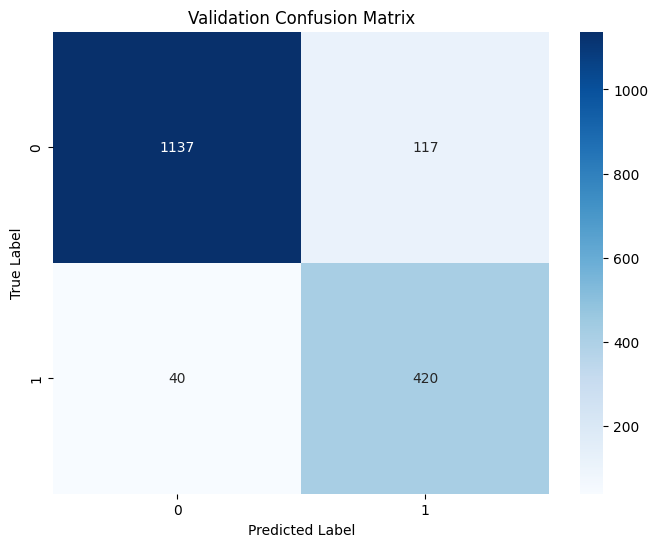

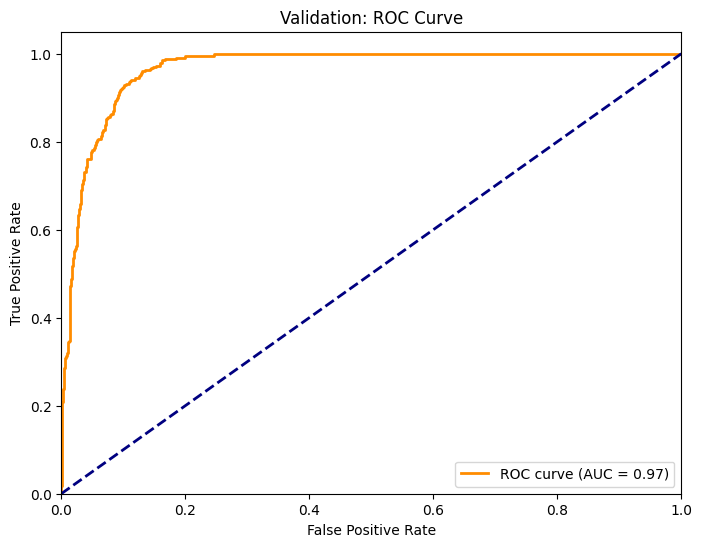

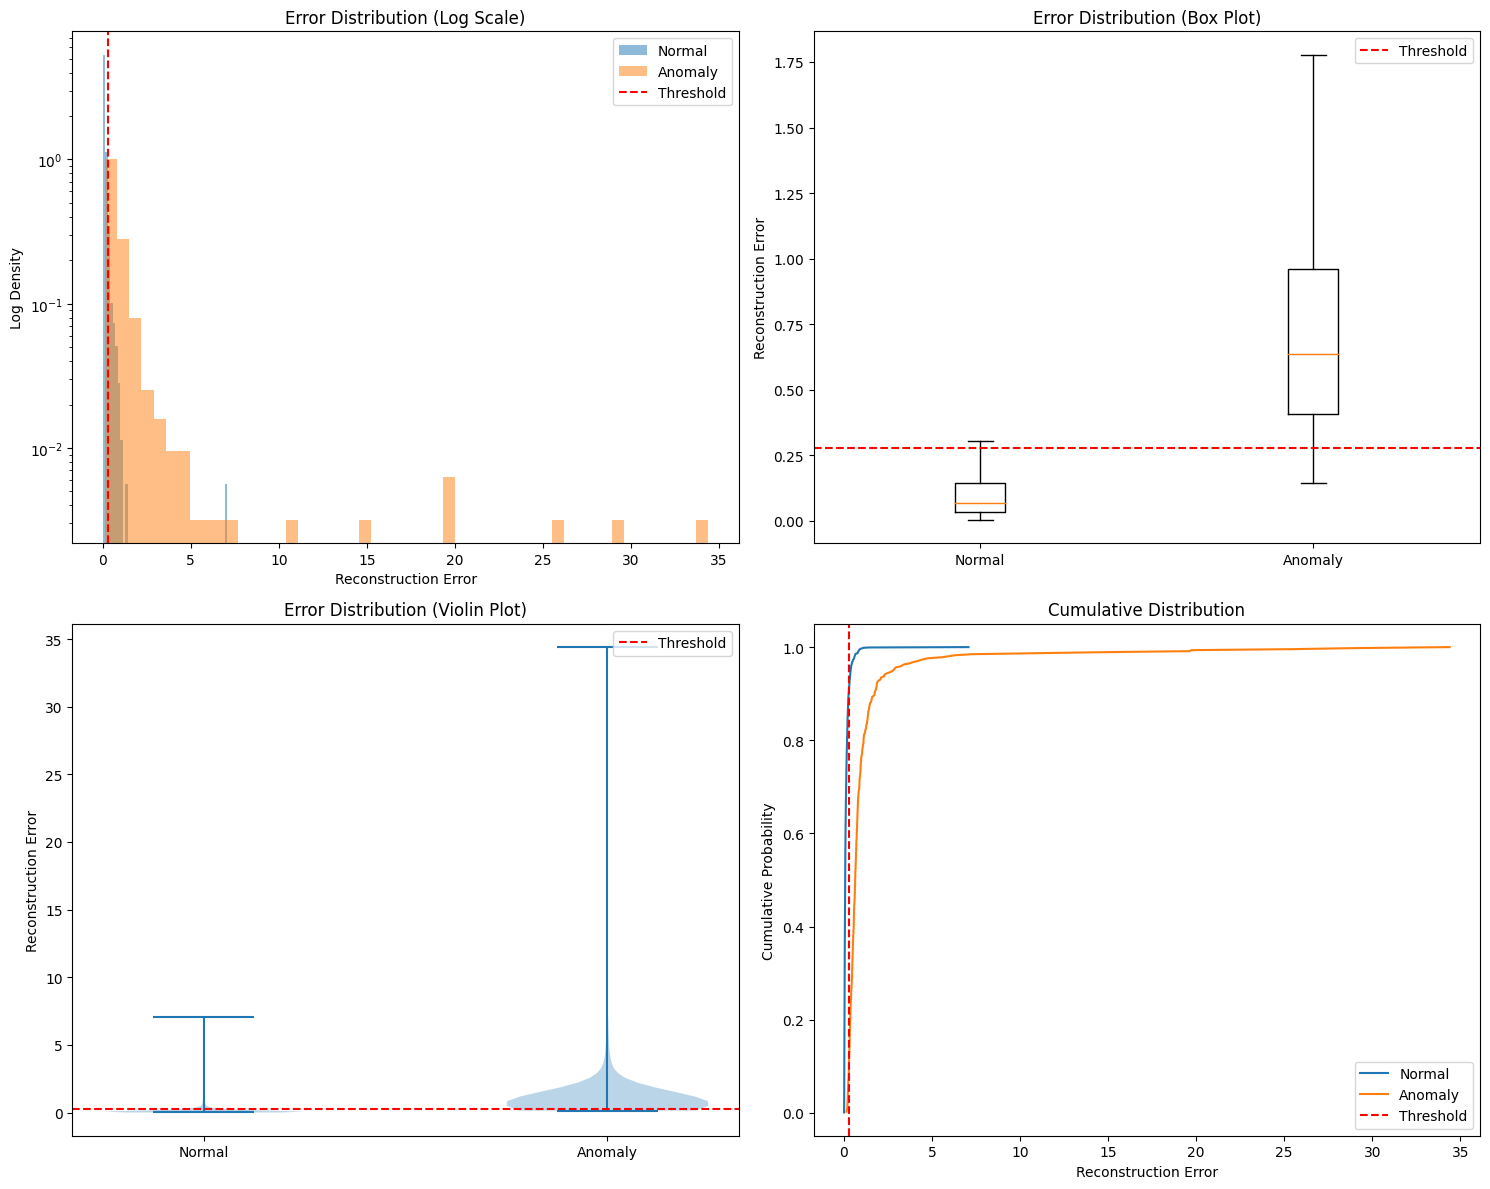

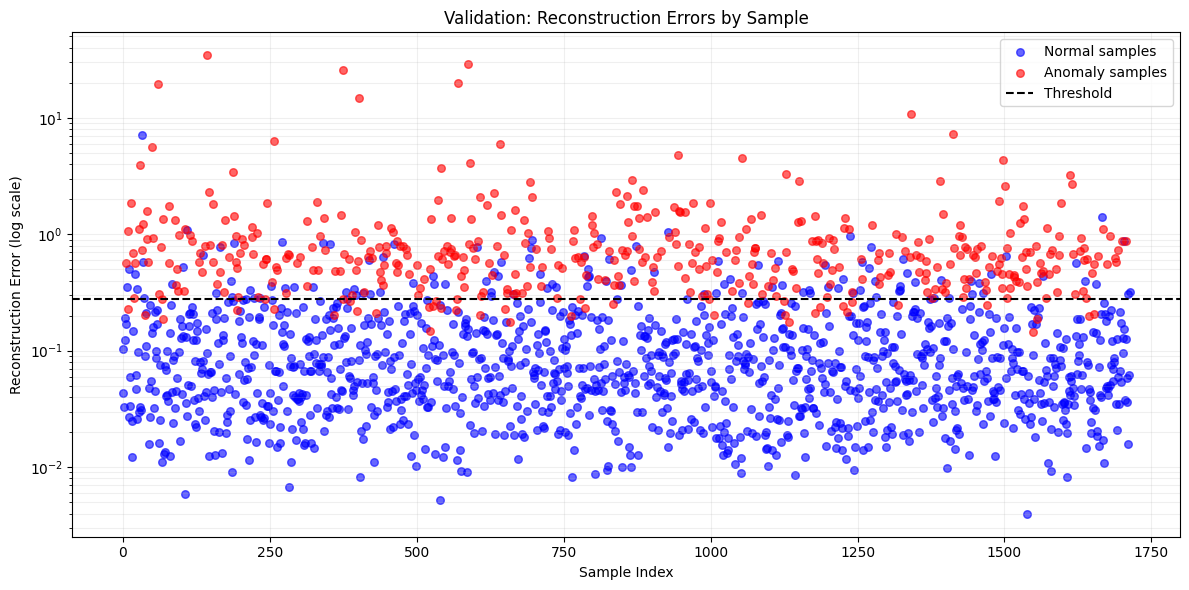

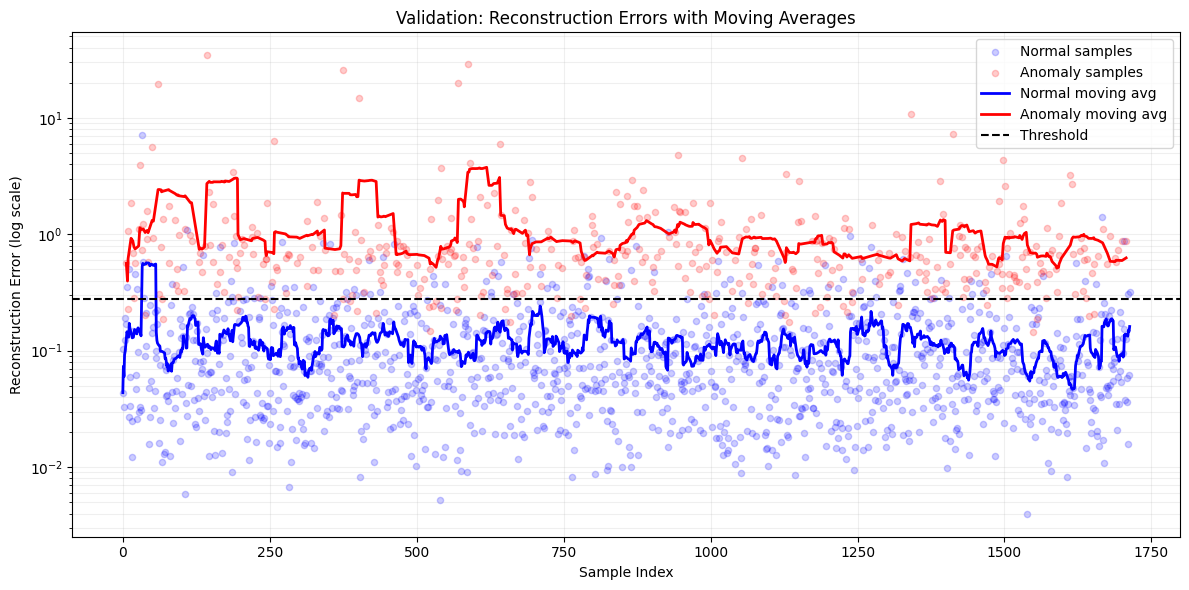

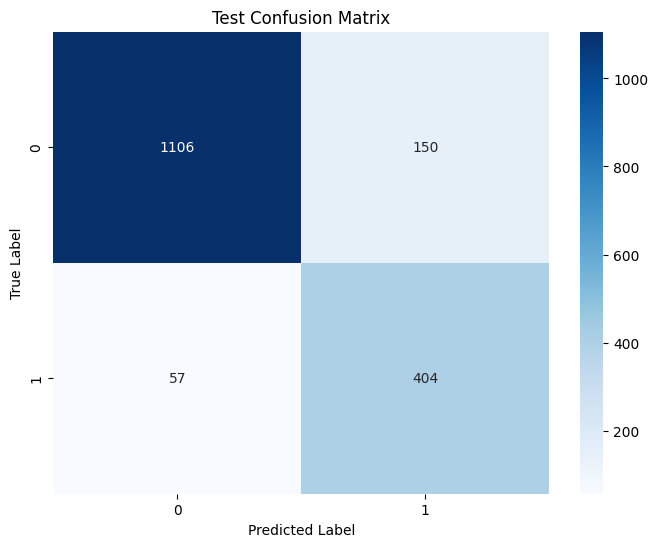

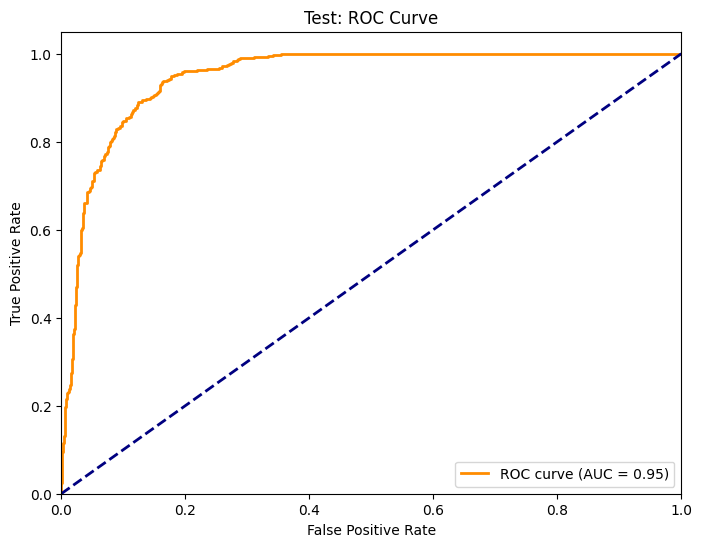

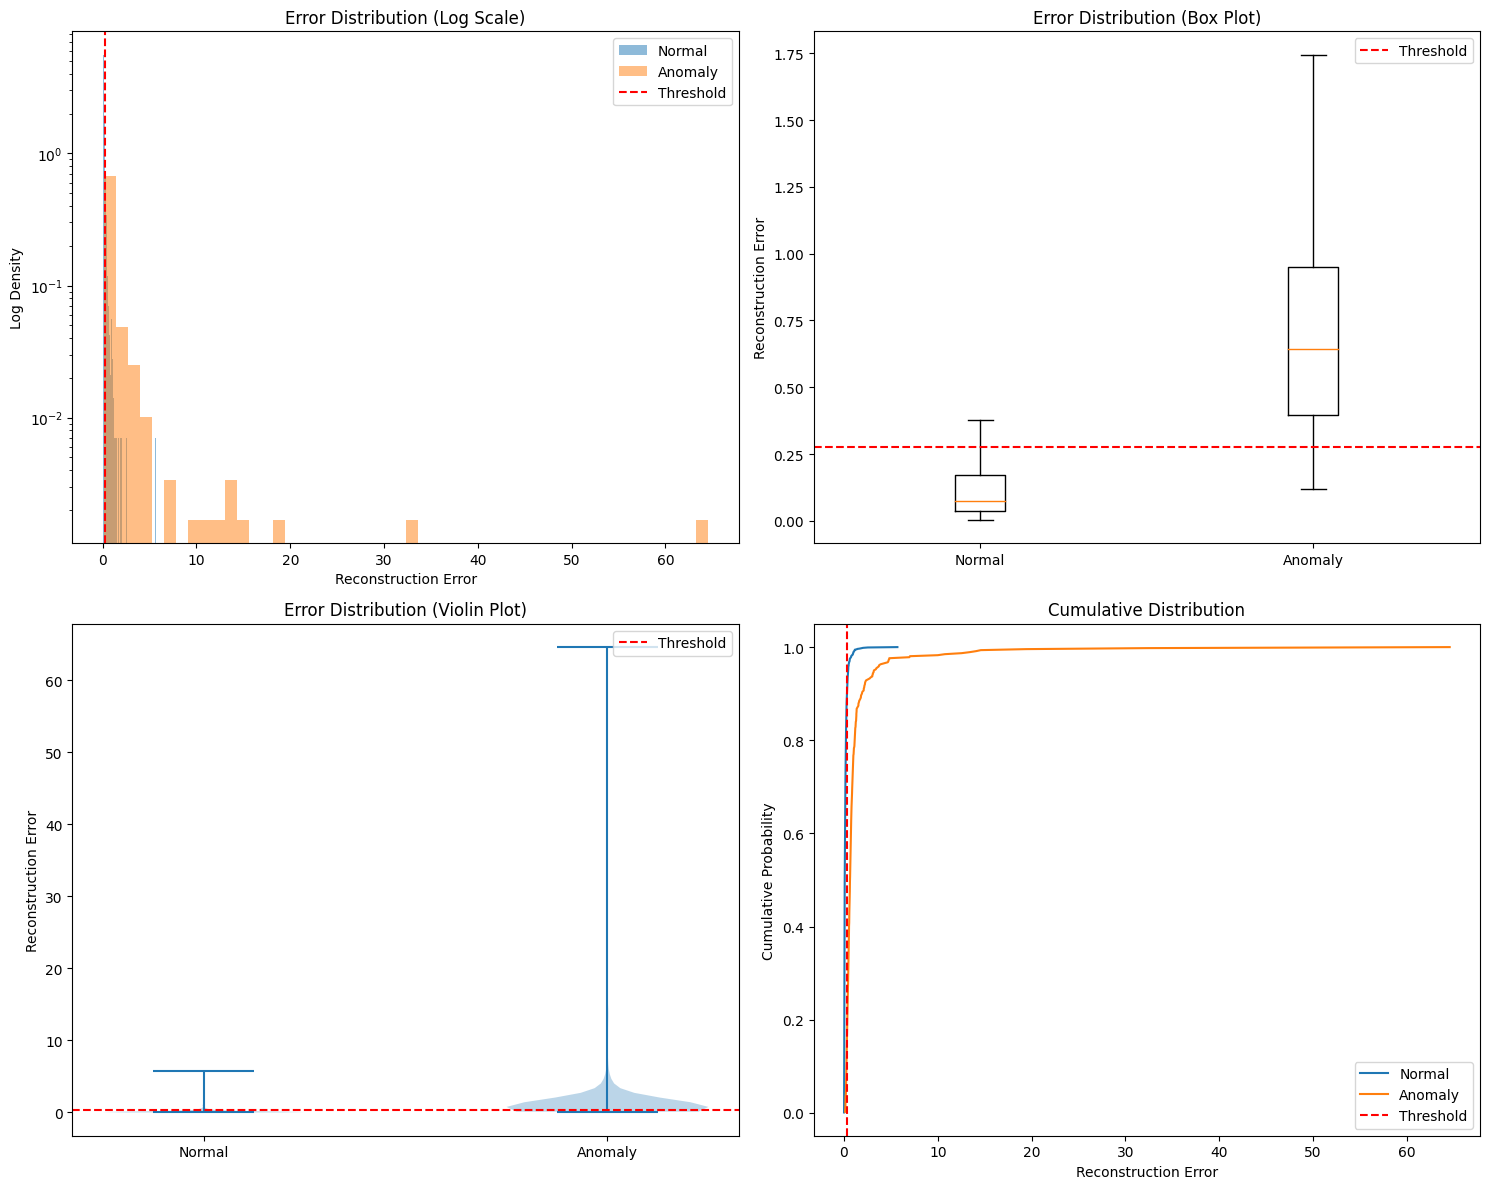

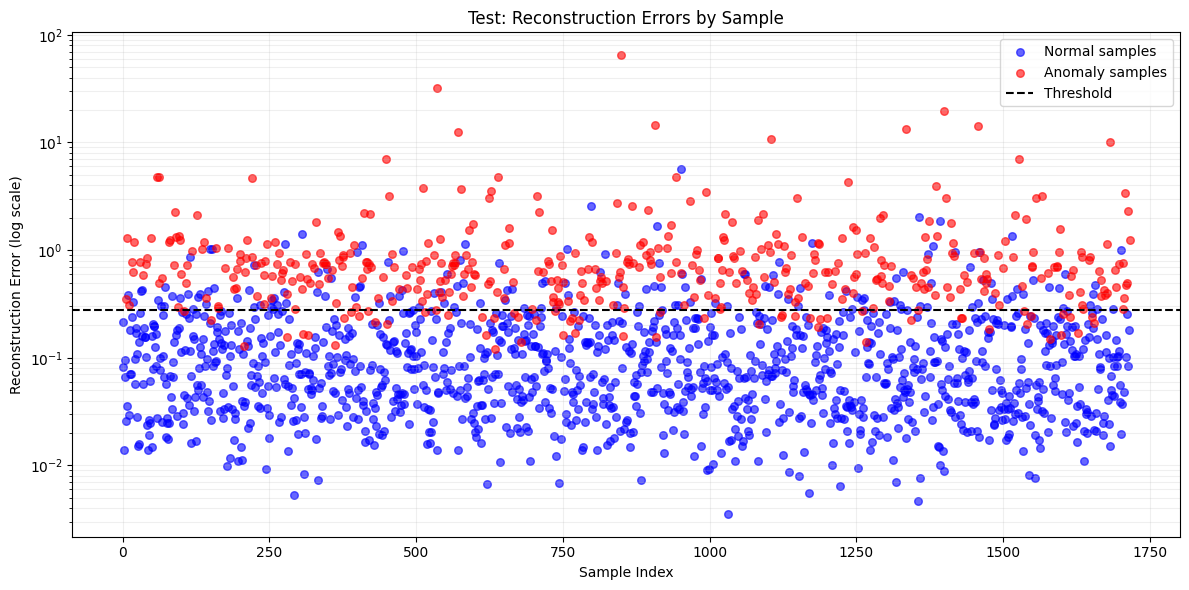

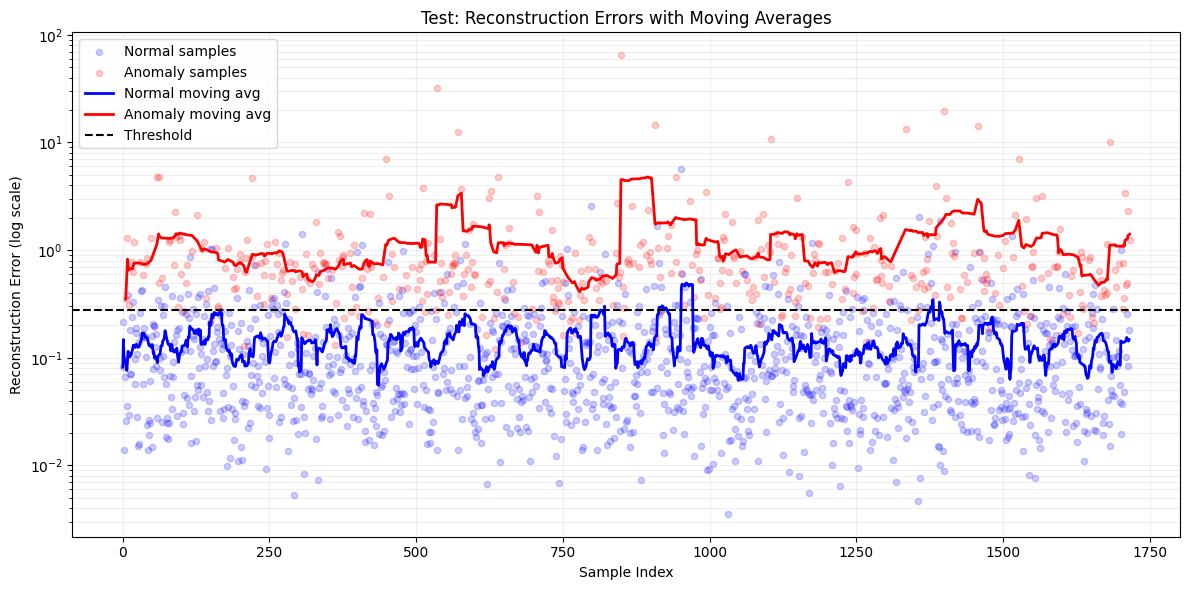

In [11]:
# 9. Visualizations
# ---------------------------------------

def plot_evaluation_visualizations(results, set_name, threshold):
    """
    Generates enhanced evaluation visualizations
    """
    # Confusion Matrix
    cm = confusion_matrix(results['labels'], results['predictions'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{set_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(results['labels'], results['errors'])
    auc_score = roc_auc_score(results['labels'], results['errors'])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
            label=f'ROC curve (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{set_name}: ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    # Enhanced Error Distribution Visualizations
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Regular histogram with log scale
    normal_errors = results['errors'][results['labels'] == 0]
    anomaly_errors = results['errors'][results['labels'] == 1]
    
    ax1.hist(normal_errors, bins=50, alpha=0.5, label='Normal', density=True)
    ax1.hist(anomaly_errors, bins=50, alpha=0.5, label='Anomaly', density=True)
    ax1.axvline(x=threshold, color='r', linestyle='--', label='Threshold')
    ax1.set_yscale('log')
    ax1.set_xlabel('Reconstruction Error')
    ax1.set_ylabel('Log Density')
    ax1.set_title('Error Distribution (Log Scale)')
    ax1.legend()
    
    # 2. Box plot comparison
    ax2.boxplot([normal_errors, anomaly_errors], 
                labels=['Normal', 'Anomaly'],
                showfliers=False)  # Optional: hide outliers for better visibility
    ax2.set_ylabel('Reconstruction Error')
    ax2.set_title('Error Distribution (Box Plot)')
    ax2.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
    ax2.legend()
    
    # 3. Violin plot
    ax3.violinplot([normal_errors, anomaly_errors])
    ax3.set_xticks([1, 2])
    ax3.set_xticklabels(['Normal', 'Anomaly'])
    ax3.set_ylabel('Reconstruction Error')
    ax3.set_title('Error Distribution (Violin Plot)')
    ax3.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
    ax3.legend()
    
    # 4. ECDF (Empirical Cumulative Distribution Function)
    def ecdf(data):
        x = np.sort(data)
        y = np.arange(1, len(data) + 1) / len(data)
        return x, y
    
    x_normal, y_normal = ecdf(normal_errors)
    x_anomaly, y_anomaly = ecdf(anomaly_errors)
    
    ax4.plot(x_normal, y_normal, label='Normal')
    ax4.plot(x_anomaly, y_anomaly, label='Anomaly')
    ax4.axvline(x=threshold, color='r', linestyle='--', label='Threshold')
    ax4.set_xlabel('Reconstruction Error')
    ax4.set_ylabel('Cumulative Probability')
    ax4.set_title('Cumulative Distribution')
    ax4.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Enhanced Error scatter plot with threshold and log scale
    plt.figure(figsize=(12, 6))
    
    # Create separate scatter plots for each class for better legend control
    plt.yscale('log')
    plt.scatter(np.where(results['labels'] == 0)[0], 
               results['errors'][results['labels'] == 0] + 1e-10,
               c='blue', alpha=0.6, s=30, label='Normal samples')
    plt.scatter(np.where(results['labels'] == 1)[0], 
               results['errors'][results['labels'] == 1] + 1e-10,
               c='red', alpha=0.6, s=30, label='Anomaly samples')
    
    plt.axhline(y=threshold, color='black', linestyle='--', label='Threshold')
    
    # Customize plot
    plt.xlabel('Sample Index')
    plt.ylabel('Reconstruction Error (log scale)')
    plt.title(f'{set_name}: Reconstruction Errors by Sample')
    
    # Add grid for better readability
    plt.grid(True, which="both", ls="-", alpha=0.2)
    
    # Add legend
    plt.legend()
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    
    # Optional: Add a second visualization showing error distribution in bins
    plt.figure(figsize=(12, 6))
    
    # Calculate moving average of errors for each class
    window = max(len(results['errors']) // 100, 1)  # Adaptive window size
    
    def moving_average(data, labels, window_size):
        indices = np.arange(len(data))
        normal_mask = labels == 0
        anomaly_mask = labels == 1
        
        # Compute moving averages for each class
        normal_avg = pd.Series(data[normal_mask]).rolling(window_size, min_periods=1).mean()
        anomaly_avg = pd.Series(data[anomaly_mask]).rolling(window_size, min_periods=1).mean()
        
        return (indices[normal_mask], normal_avg, 
                indices[anomaly_mask], anomaly_avg)

    normal_idx, normal_avg, anomaly_idx, anomaly_avg = moving_average(
        results['errors'], results['labels'], window)

    plt.yscale('log')
    plt.scatter(normal_idx, results['errors'][results['labels'] == 0] + 1e-10, 
               c='blue', alpha=0.2, s=20, label='Normal samples')
    plt.scatter(anomaly_idx, results['errors'][results['labels'] == 1] + 1e-10, 
               c='red', alpha=0.2, s=20, label='Anomaly samples')
    
    # Plot moving averages
    plt.plot(normal_idx, normal_avg + 1e-10, 'b-', linewidth=2, 
             label='Normal moving avg')
    plt.plot(anomaly_idx, anomaly_avg + 1e-10, 'r-', linewidth=2, 
             label='Anomaly moving avg')
    
    plt.axhline(y=threshold, color='black', linestyle='--', label='Threshold')
    
    plt.xlabel('Sample Index')
    plt.ylabel('Reconstruction Error (log scale)')
    plt.title(f'{set_name}: Reconstruction Errors with Moving Averages')
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.tight_layout()
    plt.show()

# Generate visualizations for both sets
plot_evaluation_visualizations(val_results, "Validation", optimal_threshold)
plot_evaluation_visualizations(test_results, "Test", optimal_threshold)

In [12]:
# from sklearn.ensemble import IsolationForest
# from sklearn.svm import OneClassSVM
# from scipy.stats import gaussian_kde  
# from scipy import stats

# def comprehensive_verification(data, model, train_dataloader, test_dataloader, threshold):
#     """
#     Run all verification checks
#     """
#     print("="*50)
#     print("RUNNING COMPREHENSIVE VERIFICATION")
#     print("="*50)
    
#     # 1. Verify Data Separation
#     print("\n1. DATA SEPARATION VERIFICATION")
#     print("-"*50)
    
#     def verify_data_separation(data):
#         data = data.copy()
#         data['sample_id'] = range(len(data))
        
#         # Process data as before (you'll need to modify this based on your exact preprocessing)
#         data_sorted = data.sort_values('outlier')
#         inliers_count = (data_sorted['outlier'] == 0).sum()
#         train_size = int(0.75 * inliers_count)
        
#         train_ids = set(data_sorted.iloc[:train_size]['sample_id'])
        
#         remaining_inliers = data_sorted.iloc[train_size:inliers_count]
#         outliers = data_sorted.iloc[inliers_count:]
        
#         val_test_size = min(len(remaining_inliers) // 2, len(outliers) // 2)
        
#         val_inliers = remaining_inliers.iloc[:val_test_size]
#         val_outliers = outliers.iloc[:val_test_size]
#         val_data = pd.concat([val_inliers, val_outliers])
        
#         test_inliers = remaining_inliers.iloc[val_test_size:2*val_test_size]
#         test_outliers = outliers.iloc[val_test_size:2*val_test_size]
#         test_data = pd.concat([test_inliers, test_outliers])
        
#         val_ids = set(val_data['sample_id'])
#         test_ids = set(test_data['sample_id'])
        
#         print("Overlap train-val:", len(train_ids.intersection(val_ids)))
#         print("Overlap train-test:", len(train_ids.intersection(test_ids)))
#         print("Overlap val-test:", len(val_ids.intersection(test_ids)))
        
#         return train_ids, val_ids, test_ids
    
#     train_ids, val_ids, test_ids = verify_data_separation(data)
    
#     # 2. Compare with Traditional Models
#     print("\n2. MODEL COMPARISON")
#     print("-"*50)
    
#     def compare_models(X_train, X_test, y_test):
#         # Prepare data
#         X_train = X_train.numpy() if isinstance(X_train, torch.Tensor) else X_train
#         X_test = X_test.numpy() if isinstance(X_test, torch.Tensor) else X_test
#         y_test = y_test.numpy() if isinstance(y_test, torch.Tensor) else y_test
        
#         # Isolation Forest
#         print("Training Isolation Forest...")
#         iso_forest = IsolationForest(random_state=42, contamination=0.1)
#         iso_forest.fit(X_train)
#         iso_preds = iso_forest.predict(X_test)
#         iso_preds = [1 if x == -1 else 0 for x in iso_preds]
        
#         # One-class SVM
#         print("Training One-class SVM...")
#         ocsvm = OneClassSVM(kernel='rbf', nu=0.1)
#         ocsvm.fit(X_train)
#         svm_preds = ocsvm.predict(X_test)
#         svm_preds = [1 if x == -1 else 0 for x in svm_preds]
        
#         # Get autoencoder predictions
#         print("Getting Autoencoder predictions...")
#         ae_errors = []
#         model.eval()
#         with torch.no_grad():
#             for batch, _ in test_dataloader:
#                 recon = model(batch)
#                 error = torch.mean((batch - recon) ** 2, dim=1)
#                 ae_errors.extend(error.cpu().numpy())
#         ae_preds = (np.array(ae_errors) > threshold).astype(int)
        
#         # Calculate metrics
#         print("\nModel Comparison Results:")
#         print("Autoencoder F1:", f1_score(y_test, ae_preds))
#         print("Isolation Forest F1:", f1_score(y_test, iso_preds))
#         print("One-class SVM F1:", f1_score(y_test, svm_preds))
        
#     # Get training and test data for traditional models
#     train_data = next(iter(train_dataloader))[0]
#     test_data = []
#     test_labels = []
#     for batch, labels in test_dataloader:
#         test_data.append(batch)
#         test_labels.append(labels)
#     test_data = torch.cat(test_data)
#     test_labels = torch.cat(test_labels)
    
#     compare_models(train_data, test_data, test_labels)
    
#     # 3. Verify Metrics Calculation
#     print("\n3. METRICS CALCULATION VERIFICATION")
#     print("-"*50)
    
#     def verify_metrics_calculation(model, test_dataloader, threshold):
#         all_errors = []
#         all_labels = []
        
#         model.eval()
#         with torch.no_grad():
#             for batch, labels in test_dataloader:
#                 recon = model(batch)
#                 error = torch.mean((batch - recon) ** 2, dim=1)
#                 all_errors.extend(error.cpu().numpy())
#                 all_labels.extend(labels.cpu().numpy())
        
#         all_errors = np.array(all_errors)
#         all_labels = np.array(all_labels)
#         predictions = (all_errors > threshold).astype(int)
        
#         tp = np.sum((predictions == 1) & (all_labels == 1))
#         fp = np.sum((predictions == 1) & (all_labels == 0))
#         fn = np.sum((predictions == 0) & (all_labels == 1))
        
#         precision = tp / (tp + fp) if (tp + fp) > 0 else 0
#         recall = tp / (tp + fn) if (tp + fn) > 0 else 0
#         f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
#         print("Manual calculation results:")
#         print(f"Precision: {precision:.4f}")
#         print(f"Recall: {recall:.4f}")
#         print(f"F1-Score: {f1:.4f}")
        
#     verify_metrics_calculation(model, test_dataloader, threshold)
    
#     # 4. Threshold Sensitivity Analysis
#     print("\n4. THRESHOLD SENSITIVITY ANALYSIS")
#     print("-"*50)
    
#     def analyze_threshold_sensitivity(model, test_dataloader):
#         # Collect all errors
#         all_errors = []
#         all_labels = []
        
#         model.eval()
#         with torch.no_grad():
#             for batch, labels in test_dataloader:
#                 recon = model(batch)
#                 error = torch.mean((batch - recon) ** 2, dim=1)
#                 all_errors.extend(error.cpu().numpy())
#                 all_labels.extend(labels.cpu().numpy())
        
#         all_errors = np.array(all_errors)
#         all_labels = np.array(all_labels)
        
#         percentiles = range(90, 100)
#         results = []
        
#         for p in percentiles:
#             threshold = np.percentile(all_errors, p)
#             predictions = (all_errors > threshold).astype(int)
            
#             results.append({
#                 'percentile': p,
#                 'f1': f1_score(all_labels, predictions),
#                 'precision': precision_score(all_labels, predictions),
#                 'recall': recall_score(all_labels, predictions)
#             })
        
#         # Plot sensitivity
#         plt.figure(figsize=(10, 6))
#         plt.plot([r['percentile'] for r in results], 
#                  [r['f1'] for r in results], 
#                  label='F1', marker='o')
#         plt.plot([r['percentile'] for r in results], 
#                  [r['precision'] for r in results], 
#                  label='Precision', marker='s')
#         plt.plot([r['percentile'] for r in results], 
#                  [r['recall'] for r in results], 
#                  label='Recall', marker='^')
#         plt.xlabel('Percentile Threshold')
#         plt.ylabel('Score')
#         plt.title('Threshold Sensitivity Analysis')
#         plt.legend()
#         plt.grid(True)
#         plt.show()
        
#         # Print best F1 score and corresponding percentile
#         best_result = max(results, key=lambda x: x['f1'])
#         print(f"Best F1 score: {best_result['f1']:.4f} at {best_result['percentile']}th percentile")
        
#     analyze_threshold_sensitivity(model, test_dataloader)
    
#     # 5. Error Distribution Analysis
#     print("\n5. ERROR DISTRIBUTION ANALYSIS")
#     print("-"*50)
    
#     def verify_error_distribution(model, test_dataloader, threshold):
#         normal_errors = []
#         anomaly_errors = []
        
#         model.eval()
#         with torch.no_grad():
#             for batch, labels in test_dataloader:
#                 recon = model(batch)
#                 errors = torch.mean((batch - recon) ** 2, dim=1)
                
#                 normal_errors.extend(errors[labels == 0].cpu().numpy())
#                 anomaly_errors.extend(errors[labels == 1].cpu().numpy())
        
#         # Plot distribution
#         plt.figure(figsize=(12, 6))
        
#         # Plot histograms
#         plt.hist(normal_errors, bins=50, alpha=0.5, label='Normal', density=True)
#         plt.hist(anomaly_errors, bins=50, alpha=0.5, label='Anomaly', density=True)
#         plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
        
#         # Add KDE plots
#         normal_kde = gaussian_kde(normal_errors)
#         anomaly_kde = gaussian_kde(anomaly_errors)
#         x_range = np.linspace(min(min(normal_errors), min(anomaly_errors)),
#                             max(max(normal_errors), max(anomaly_errors)), 200)
#         plt.plot(x_range, normal_kde(x_range), 'b-', alpha=0.7)
#         plt.plot(x_range, anomaly_kde(x_range), 'g-', alpha=0.7)
        
#         plt.xlabel('Reconstruction Error')
#         plt.ylabel('Density')
#         plt.title('Error Distribution Analysis')
#         plt.legend()
#         plt.grid(True, alpha=0.3)
#         plt.show()
        
#         # Print statistics
#         print("\nError Distribution Statistics:")
#         print(f"Normal samples - Mean: {np.mean(normal_errors):.4f}, Std: {np.std(normal_errors):.4f}")
#         print(f"Anomaly samples - Mean: {np.mean(anomaly_errors):.4f}, Std: {np.std(anomaly_errors):.4f}")
#         print(f"Threshold: {threshold:.4f}")
        
#         # Calculate overlap percentage
#         normal_above = np.sum(np.array(normal_errors) > threshold)
#         anomaly_below = np.sum(np.array(anomaly_errors) <= threshold)
#         print(f"\nNormal samples above threshold: {normal_above/len(normal_errors)*100:.2f}%")
#         print(f"Anomaly samples below threshold: {anomaly_below/len(anomaly_errors)*100:.2f}%")
        
#     verify_error_distribution(model, test_dataloader, threshold)
    
#     # 6. Feature Analysis
#     print("\n6. FEATURE IMPORTANCE ANALYSIS")
#     print("-"*50)
    
#     def analyze_feature_importance(model, test_dataloader):
#         feature_errors = []
#         labels = []
        
#         model.eval()
#         with torch.no_grad():
#             for batch, batch_labels in test_dataloader:
#                 recon = model(batch)
#                 # Calculate error for each feature
#                 errors = (batch - recon) ** 2
#                 feature_errors.append(errors.cpu().numpy())
#                 labels.extend(batch_labels.cpu().numpy())
        
#         feature_errors = np.concatenate(feature_errors, axis=0)
#         labels = np.array(labels)
        
#         # Calculate mean error per feature for normal and anomaly samples
#         normal_errors = feature_errors[labels == 0].mean(axis=0)
#         anomaly_errors = feature_errors[labels == 1].mean(axis=0)
        
#         # Plot feature importance
#         plt.figure(figsize=(15, 6))
#         x = np.arange(len(normal_errors))
#         width = 0.35
        
#         plt.bar(x - width/2, normal_errors, width, label='Normal')
#         plt.bar(x + width/2, anomaly_errors, width, label='Anomaly')
        
#         plt.xlabel('Feature Index')
#         plt.ylabel('Mean Reconstruction Error')
#         plt.title('Feature-wise Reconstruction Error Analysis')
#         plt.legend()
#         plt.xticks(x[::5])
#         plt.grid(True, alpha=0.3)
#         plt.show()
        
#         # Print most discriminative features
#         feature_diff = np.abs(anomaly_errors - normal_errors)
#         top_features = np.argsort(feature_diff)[-5:][::-1]
#         print("\nTop 5 most discriminative features:")
#         for idx in top_features:
#             print(f"Feature {idx}: Normal error = {normal_errors[idx]:.4f}, "
#                   f"Anomaly error = {anomaly_errors[idx]:.4f}, "
#                   f"Difference = {feature_diff[idx]:.4f}")
    
#     analyze_feature_importance(model, test_dataloader)

# # Usage
# comprehensive_verification(data, model, train_dataloader, test_dataloader, threshold)